# 2b Reason: Low Precision Features
Here, I will analyze how low precision in the features can influence confound-leakage.
The lowest precision of a feature would be binary 0 and 1, but later I will also look
at precisions, where steps are lower than 1.

Config like imports and path

In [1]:
from matplotlib import ticker
from functools import partial
from copy import copy
import matplotlib as mpl
import numpy as np
import joblib
import pandas as pd
from julearn import run_cross_validation
from sklearn.model_selection import RepeatedKFold, KFold, RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from dtreeviz.trees import dtreeviz

from leakconfound.plotting import mm_to_inch
from leakconfound.analyses.utils import save_paper_val

from sciplotlib import style

In [2]:
np.random.seed(6252006)

base_save_paper = "./paper_val/"
base_dir = '../../'

colors = ['#E64B35', '#4DBBD5', '#00A087', '#3C5488',
          '#F39B7F', '#8491B4', '#91D1C2FF', '#DC0000',
          '#7E6148', '#B09C85']
red = colors[0]
blue = colors[1]
green = colors[2]
purple = colors[5]

mpl.style.use(style.get_style('nature-reviews'))
mpl.rc('xtick', labelsize=11)
mpl.rc('ytick', labelsize=11)
mpl.rc('axes', labelsize=12, titlesize=12)
mpl.rc('figure', dpi=300)
mpl.rc('figure.subplot', wspace=mm_to_inch(4), hspace=mm_to_inch(7))
mpl.rc('lines', linewidth=1)

Define some functions to get distributions as I want to

In [3]:

def convert_precision(original_nbr, step=.2):
    if original_nbr % step > step/2:
        res = step * (original_nbr//step + 1)
    else:
        res = step * (original_nbr//step)
    return res


def normal_stepped(size, step=.2):

    df_normal = pd.DataFrame(
        np.random.normal(size=size),
        columns=["feat_1"]
    )
    return df_normal.assign(
        feat_2=lambda df: df["feat_1"].map(
            partial(convert_precision, step=step))
    )

## Starting with Binary Feature

In [4]:
target = np.random.normal(size=1_000)
feat = np.random.choice([0, 1], replace=True, size=1_000)
df = pd.DataFrame(dict(feat_1=feat, conf=target, target=target))

scores_1_no_rem, est_no_removal = run_cross_validation(
    X=['feat_1'], y='target', data=df,
    model=DecisionTreeRegressor(), preprocess_X=['zscore'],
    preprocess_confounds=['zscore'], cv=RepeatedKFold(),
    scoring='r2', problem_type='regression', return_estimator='final'
)
scores_1_no_rem = scores_1_no_rem.groupby('repeat').mean().test_score

scores_1, est_removed = run_cross_validation(
    X=['feat_1'], confounds=['conf'], y='target', data=df,
    model=DecisionTreeRegressor(), preprocess_X=['zscore', 'remove_confound'],
    preprocess_confounds=['zscore'], cv=RepeatedKFold(),
    scoring='r2', problem_type='regression', return_estimator='final'
)
scores_1 = scores_1.groupby('repeat').mean().test_score

print(
    'Scores random binary no removal feature  : M = '
    f'{scores_1_no_rem.mean():.4f}, sd = {scores_1_no_rem.std():.4f}'
)

save_paper_val(base_save_paper, "reasons_low_perc", "raw",
               "mean_random_binary.txt", scores_1_no_rem.mean())

save_paper_val(base_save_paper, "reasons_low_perc", "raw",
               "std_random_binary.txt", scores_1_no_rem.std())
print(
    'Scores random binary confound removed feature  : M = '
    f'{scores_1.mean():.4f}, sd = {scores_1.std():.4f}'
)

save_paper_val(base_save_paper, "reasons_low_perc", "removed",
               "mean_random_binary.txt", scores_1.mean())

save_paper_val(base_save_paper, "reasons_low_perc", "removed",
               "std_random_binary.txt", scores_1.std())

Scores random binary no removal feature  : M = -0.0068, sd = 0.0034


Scores random binary confound removed feature  : M = 0.9985, sd = 0.0003


Now let us have a closer look at what is going on

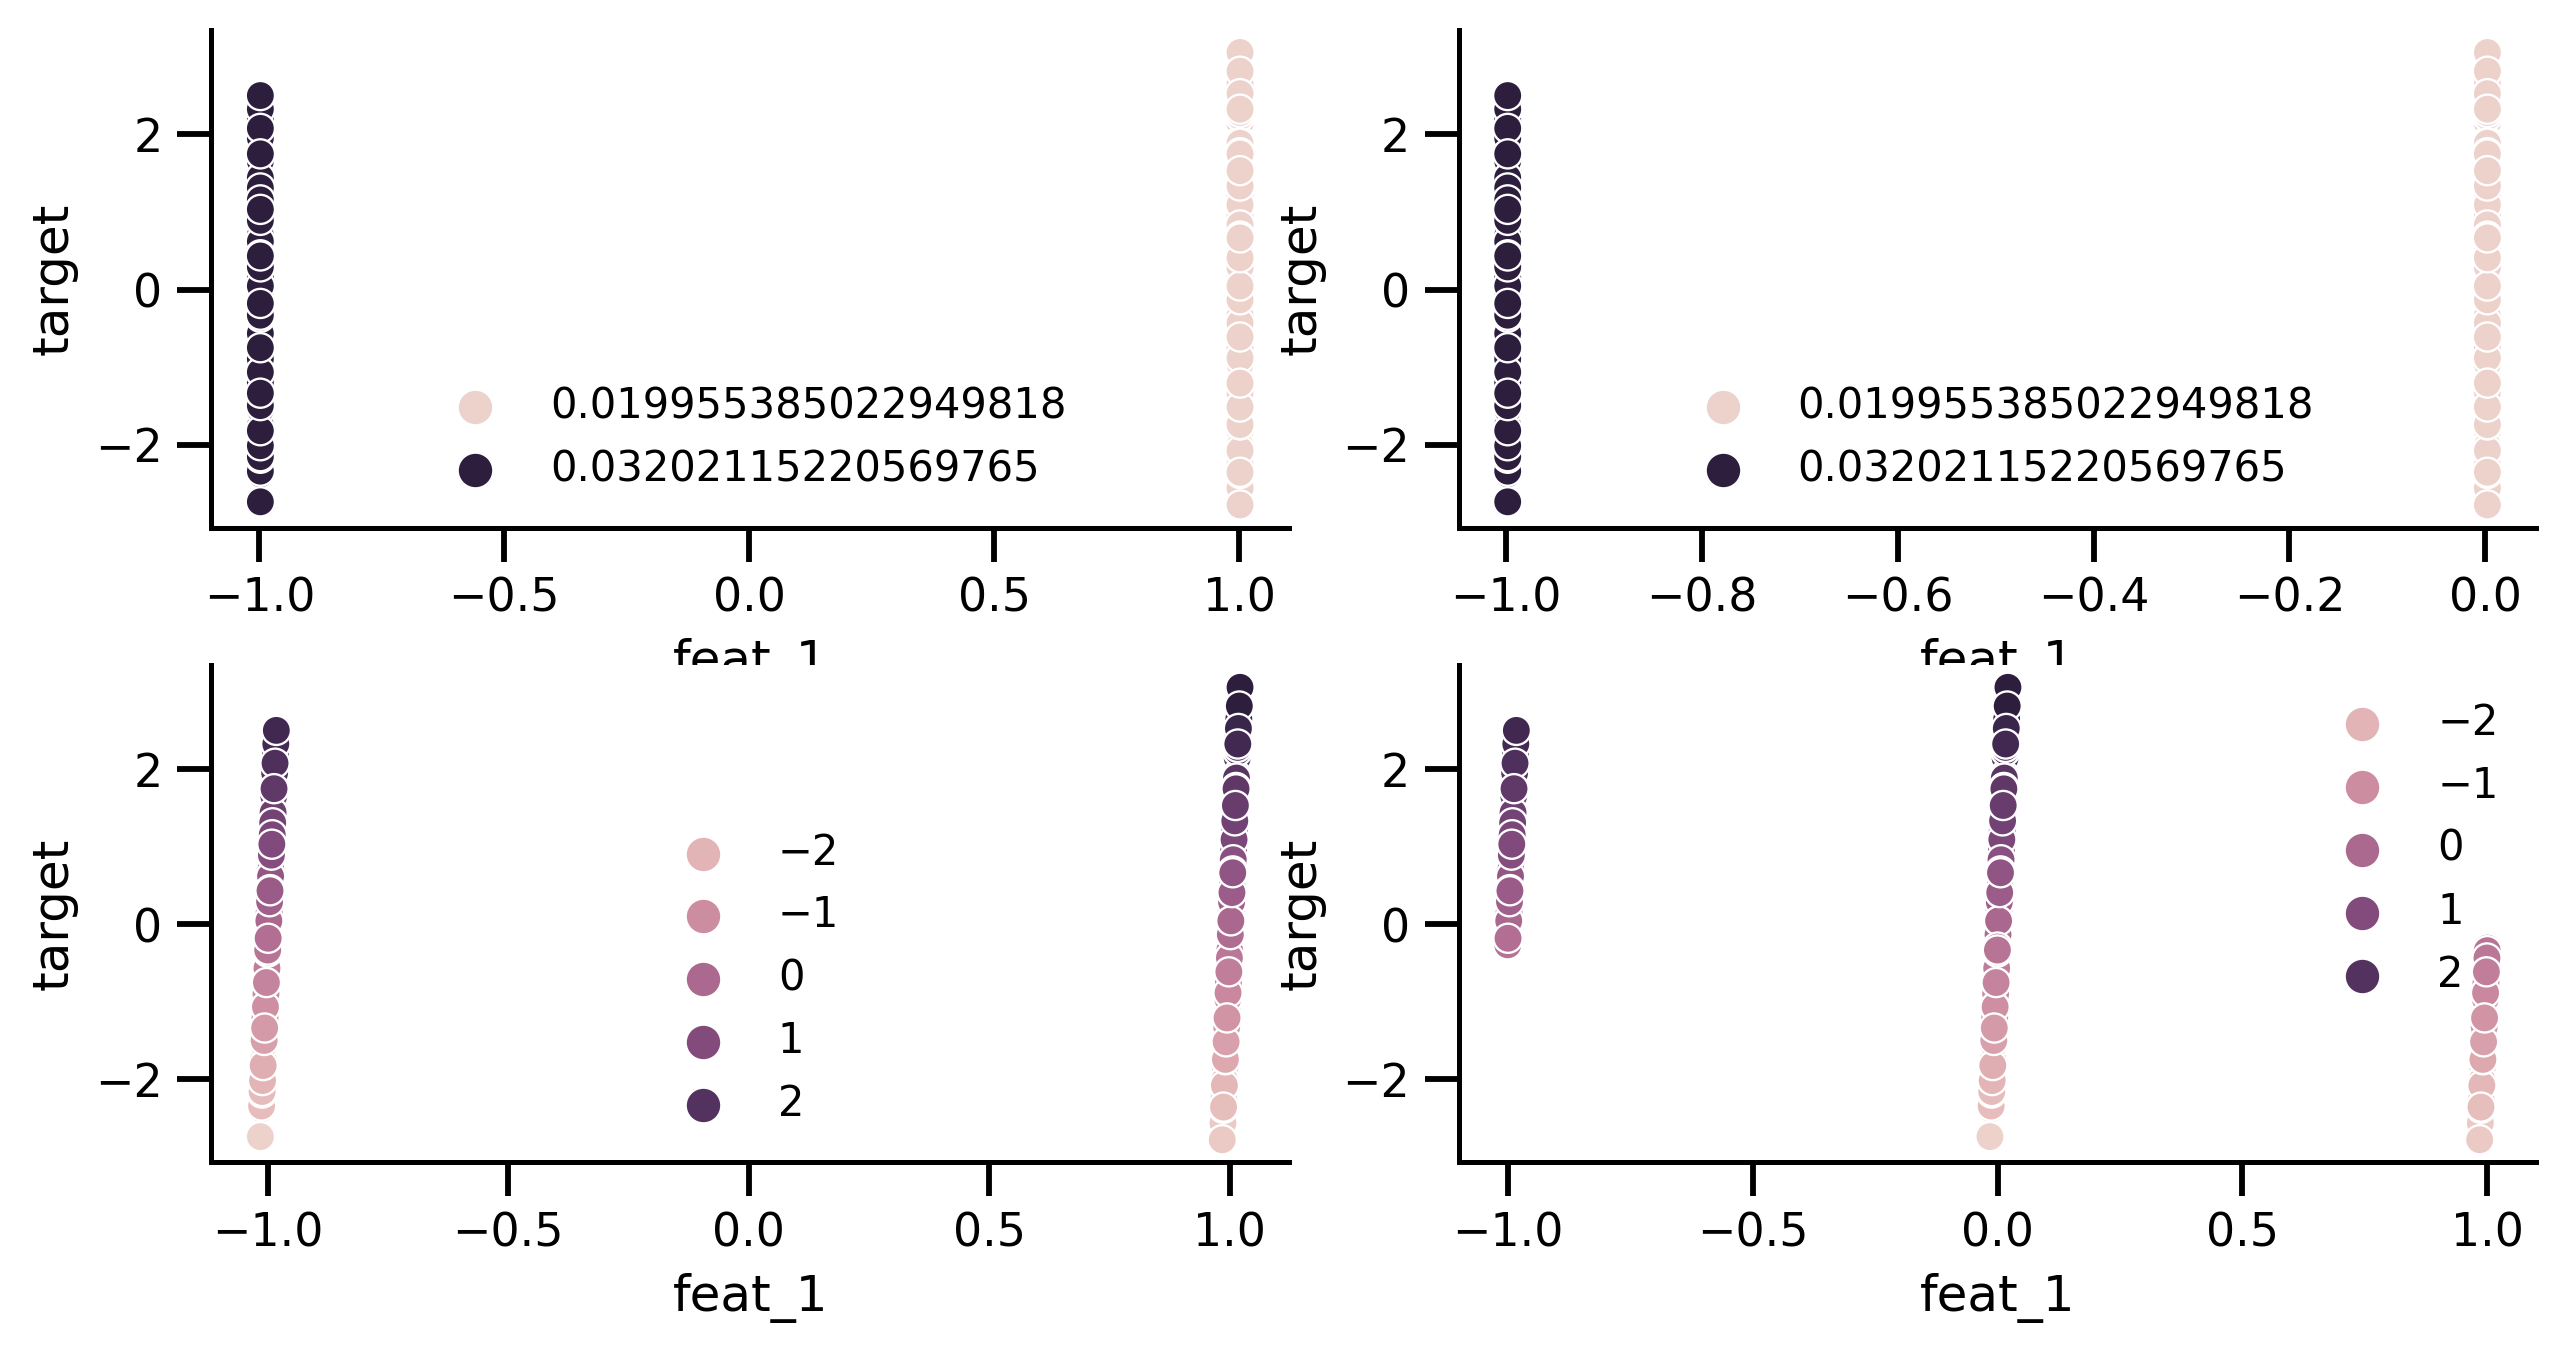

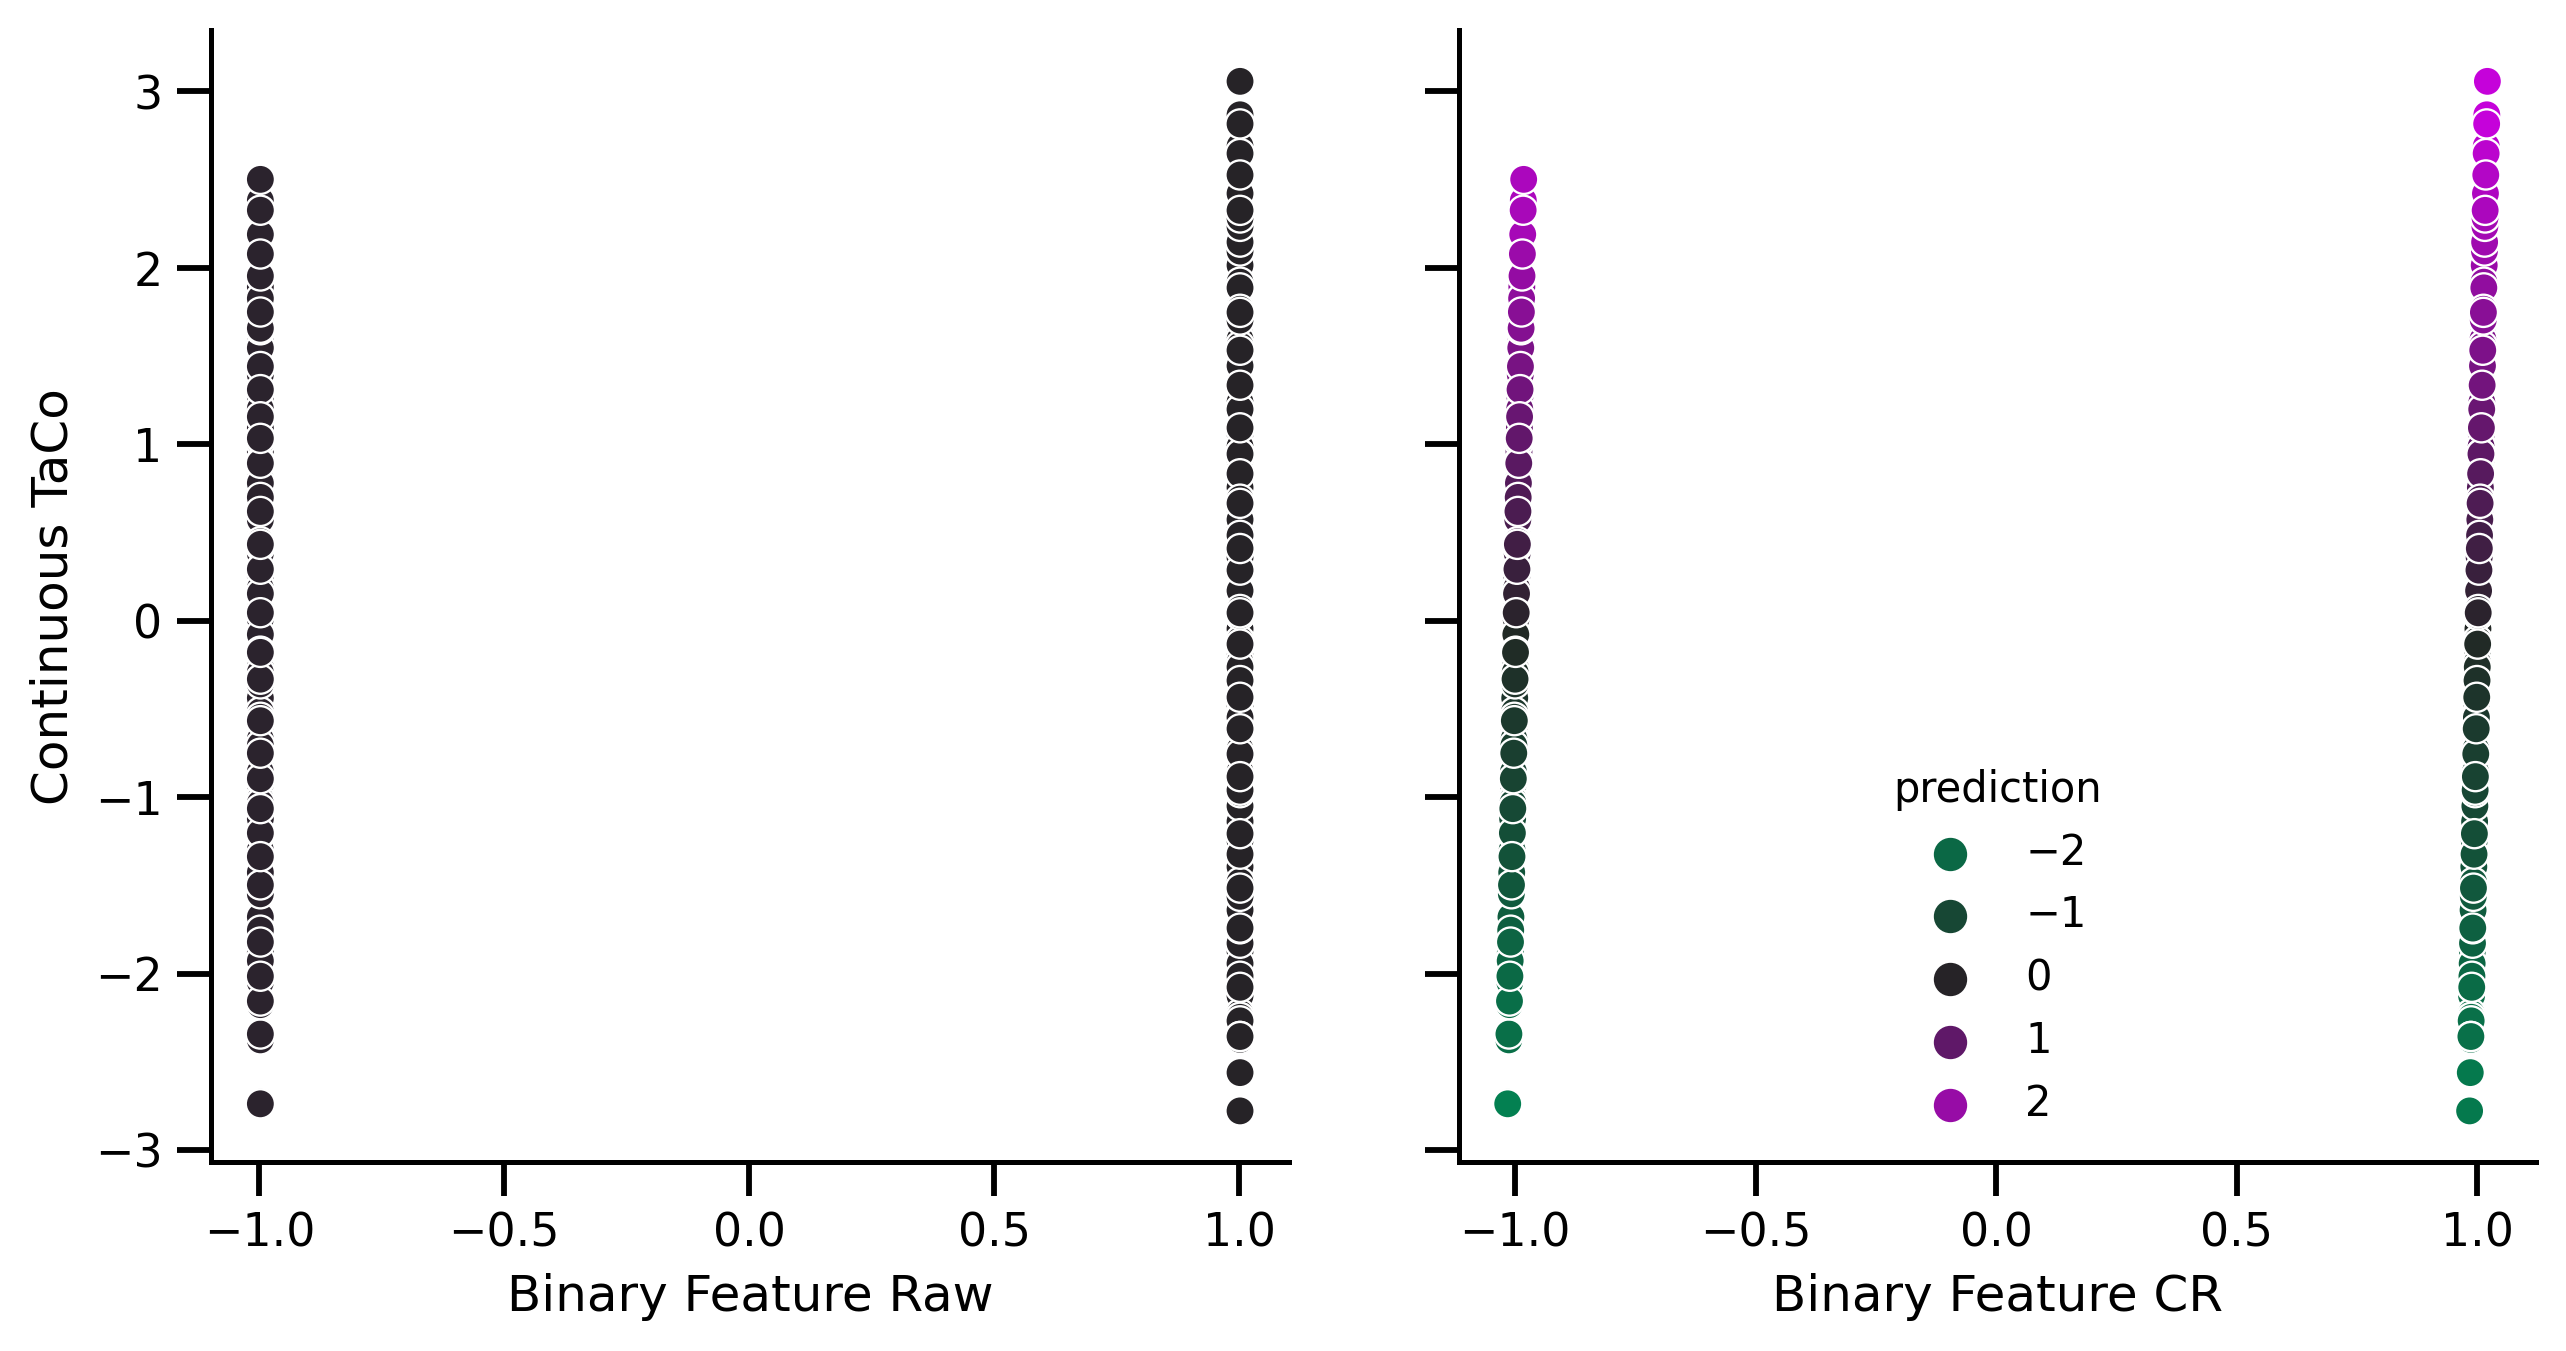

In [5]:
target = np.random.normal(size=1_000)
feat = np.random.choice([0, 1], replace=True, size=1_000)
df_test = pd.DataFrame(dict(feat_1=feat, conf=target, target=target))

pred_rem = est_removed.predict(df_test[['feat_1', 'conf']])
pred_no_rem = est_no_removal.predict(df_test[['feat_1']])

X_prep_rem, _ = est_removed.preprocess(df_test.drop(
    columns=['target']), df_test.target)
X_prep_no_rem, _ = est_no_removal.preprocess(df_test.drop(
    columns=['target', 'conf']), df_test.target)

fig, axes = plt.subplots(2, 2, figsize=[10, 5])


sns.scatterplot(x=X_prep_no_rem['feat_1'], y=df_test.target, ax=axes[0][0],
                hue=pred_no_rem)
sns.scatterplot(x=X_prep_no_rem['feat_1'].apply(lambda x: x-int(x)),
                y=df_test.target, ax=axes[0][1], hue=pred_no_rem)

sns.scatterplot(x=X_prep_rem['feat_1'], y=df_test.target, ax=axes[1][0],
                hue=pred_rem)

sns.scatterplot(x=X_prep_rem['feat_1'].apply(lambda x: x-int(x)),
                y=df_test.target, ax=axes[1][1], hue=pred_rem)

fig, axes = plt.subplots(1, 2, figsize=[10, 5])

palette = sns.diverging_palette(
    145, 300, s=100, as_cmap=True,  center="dark",)
normalize = mpl.colors.Normalize(vmin=-3, vmax=3)
sns.scatterplot(x=X_prep_no_rem['feat_1'], y=df_test.target, ax=axes[0],
                palette=palette,

                hue=pred_no_rem, hue_norm=normalize)
sns.scatterplot(x=X_prep_rem['feat_1'], y=df_test.target, ax=axes[1],

                palette=palette,
                hue=pred_rem, hue_norm=normalize)
axes[0].get_legend().set_visible(False)
axes[1].get_legend().set_title('prediction')

axes[0].set_xlabel('Binary Feature Raw')
axes[0].set_ylabel('Continuous TaCo')

axes[1].set_xlabel('Binary Feature CR')
axes[1].set_yticklabels([])
axes[1].set_ylabel('')

fig.savefig('./saved_figures/low_precision_sim.svg')

## Investigating similar Effect for Continuous Values Rounded to a Precision or Not

In [6]:

step = 0.1
target = np.random.normal(size=1_000)
df = normal_stepped(size=1_000, step=step)
df['target'] = target
df['conf'] = target

scores_1 = run_cross_validation(
    X=['feat_1'], y='target', data=df, confounds=['conf'],
    model=DecisionTreeRegressor(), preprocess_X=['zscore', 'remove_confound'],
    cv=RepeatedKFold(), scoring='r2', problem_type='regression'

).groupby("repeat").mean().test_score

scores_1_no_cr = run_cross_validation(
    X=['feat_1'], y='target', data=df,
    model=DecisionTreeRegressor(), preprocess_X=['zscore'],
    cv=RepeatedKFold(), scoring='r2', problem_type='regression'

).groupby("repeat").mean().test_score

scores_2, est_removed = run_cross_validation(
    X=['feat_2'], y='target', data=df, confounds=['conf'],
    model=DecisionTreeRegressor(), preprocess_X=['zscore', 'remove_confound'],
    cv=RepeatedKFold(), scoring='r2',
    problem_type='regression', return_estimator='final',
)
scores_2 = scores_2.groupby("repeat").mean().test_score

scores_3, est_no_removal = run_cross_validation(
    X=['feat_2'], y='target', data=df,
    model=DecisionTreeRegressor(), preprocess_X=['zscore'], cv=RepeatedKFold(),
    scoring='r2', problem_type='regression', return_estimator='final'
)
scores_3 = scores_3.groupby("repeat").mean().test_score

print('Scores Random confound no removal continuous Feature: M = '
      f'{scores_1_no_cr.mean():.4f}, sd = {scores_1_no_cr.std():.4f}')

print('Scores Random confound removed continuous Feature: M = '
      f'{scores_1.mean():.4f}, sd = {scores_1.std():.4f}')

save_paper_val(base_save_paper, "reasons_low_perc", "raw",
               "mean_random_continious_cont_target_not_rounded.txt", scores_1_no_cr.mean())

save_paper_val(base_save_paper, "reasons_low_perc", "raw",
               "std_random_continious_cont_target_not_rounded.txt", scores_1_no_cr.std())

save_paper_val(base_save_paper, "reasons_low_perc", "removed",
               "mean_random_continious_cont_target_not_rounded.txt", scores_1.mean())

save_paper_val(base_save_paper, "reasons_low_perc", "removed",
               "std_random_continious_cont_target_not_rounded.txt", scores_1.std())

print('Scores Random confound removed continuous Feature with'
      f'precision of {step} : M = '
      f'{scores_2.mean():.4f}, sd = {scores_2.std():.4f}'
      )

save_paper_val(base_save_paper, "reasons_low_perc", "removed",
               "mean_random_continious_cont_target_prec_rounded.txt", scores_2.mean())

save_paper_val(base_save_paper, "reasons_low_perc", "removed",
               "std_random_continious_cont_target_prec_rounded.txt", scores_2.std())

print('Scores Random no removal continuous Feature with '
      f'precision of {step} : M = '
      f'{scores_3.mean():.4f}, sd = {scores_3.std():.4f}'
      )

save_paper_val(base_save_paper, "reasons_low_perc", "raw",
               "mean_random_continious_cont_target_prec_rounded.txt", scores_3.mean())

save_paper_val(base_save_paper, "reasons_low_perc", "raw",
               "std_random_continious_cont_target_prec_rounded.txt", scores_3.std())


Scores Random confound no removal continuous Feature: M = -1.0989, sd = 0.0611
Scores Random confound removed continuous Feature: M = -1.0280, sd = 0.0717
Scores Random confound removed continuous Feature withprecision of 0.1 : M = 0.7041, sd = 0.1646
Scores Random no removal continuous Feature with precision of 0.1 : M = -0.0845, sd = 0.0126


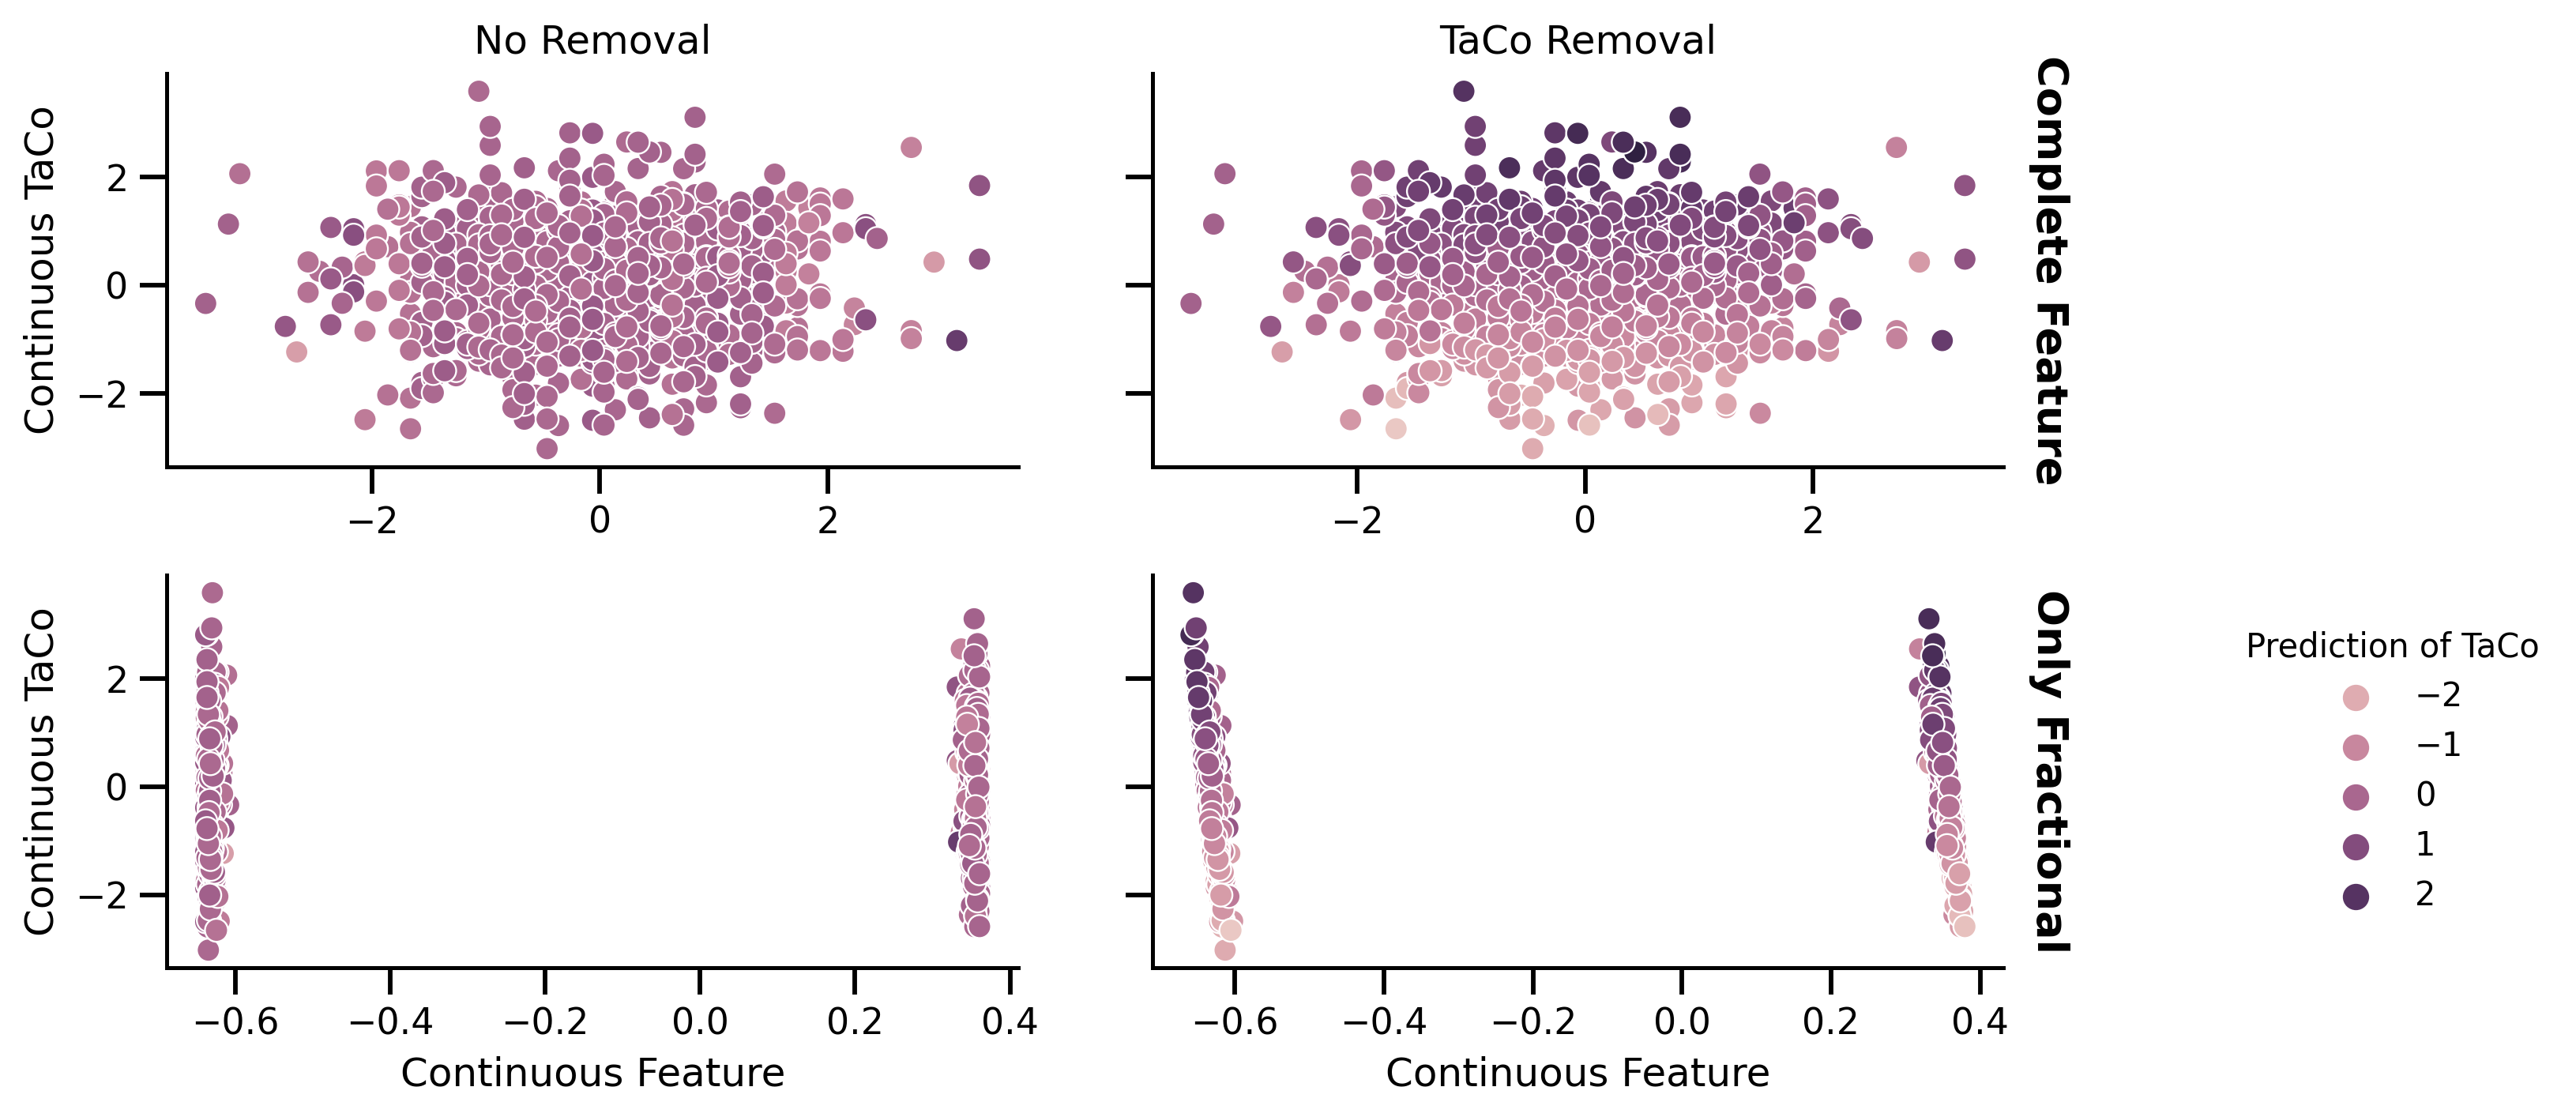

In [7]:
target_test = np.random.normal(size=1_000)
df_test = normal_stepped(size=1_000, step=step)
# df_test.columns = ['feat_2']
# df_test['feat_1'] = np.random.normal(size=1_000)
df_test['target'] = target_test
df_test['conf'] = target_test

pred_rem = est_removed.predict(df_test[['feat_2', 'conf']])
pred_no_rem = est_no_removal.predict(df_test[['feat_2']])

X_prep_rem, _ = est_removed.preprocess(df_test.drop(
    columns=['target', 'feat_1']), df_test.target)
X_prep_no_rem, _ = est_no_removal.preprocess(df_test.drop(
    columns=['target', 'feat_1', 'conf']), df_test.target)
fig, axes = plt.subplots(2, 2, figsize=[10, 5])


normalize = mpl.colors.Normalize(vmin=-3, vmax=3)
sns.scatterplot(x=X_prep_no_rem['feat_2'], y=df_test.target, ax=axes[0][0],
                hue=pred_no_rem, hue_norm=normalize)

sns.scatterplot(x=X_prep_no_rem['feat_2'].apply(lambda x: (x*10-int(x*10))),
                y=df_test.target, ax=axes[1][0], hue=pred_no_rem, hue_norm=normalize)

sns.scatterplot(x=X_prep_rem['feat_2'], y=df_test.target, ax=axes[0][1],
                hue=pred_rem, hue_norm=normalize)

g = sns.scatterplot(x=X_prep_rem['feat_2'].apply(lambda x: (x*10-int(x*10))),
                    y=df_test.target, ax=axes[1][1], hue=pred_rem, hue_norm=normalize)

axes[0][0].get_legend().set_visible(False)
axes[0][1].get_legend().set_visible(False)
axes[1][0].get_legend().set_visible(False)
g.legend(loc='center left', bbox_to_anchor=(
    1.25, 0.5), ncol=1, title='Prediction of TaCo')
axes[0][0].set_title('No Removal')
axes[0][1].set_title('TaCo Removal')

axes[1][0].set_xlabel('Continuous Feature')
axes[1][1].set_xlabel('Continuous Feature')
axes[0][0].set_xlabel('')
axes[0][1].set_xlabel('')
axes[0][0].set_ylabel('Continuous TaCo')
axes[1][0].set_ylabel('Continuous TaCo')
axes[0][1].set_ylabel('')
axes[1][1].set_ylabel('')

axes[0][1].set_yticklabels([])
axes[1][1].set_yticklabels([])

axR0 = axes[0][1].twinx()
axR0.set_yticks([])
axR0.set_ylabel('Complete Feature', rotation=270,
                labelpad=20, fontsize=13, weight='bold')

axR1 = axes[1][1].twinx()
axR1.set_yticks([])
axR1.set_ylabel('Only Fractional', rotation=270,
                labelpad=20, fontsize=13, weight='bold')

fig.savefig('./saved_figures/low_precision_cont_sim.svg')

same but now with a binary target:

In [8]:
target = np.random.choice([0, 1], size=1_000)
df = normal_stepped(size=1_000, step=step)
df['target'] = target
df['conf'] = target

scores_1 = run_cross_validation(
    X=['feat_1'], y='target', data=df, confounds=['conf'],
    model=DecisionTreeClassifier(), preprocess_X=['zscore', 'remove_confound'],
    cv=RepeatedStratifiedKFold(), scoring='roc_auc'

)
scores_1 = scores_1.groupby('repeat').mean().test_score

scores_2, est_removed = run_cross_validation(
    X=['feat_2'], y='target', data=df, confounds=['conf'],
    model=DecisionTreeClassifier(), preprocess_X=['zscore', 'remove_confound'],
    cv=RepeatedStratifiedKFold(), scoring='roc_auc',
    return_estimator='final',
)
scores_2 = scores_2.groupby('repeat').mean().test_score

scores_3, est_no_removal = run_cross_validation(
    X=['feat_2'], y='target', data=df,
    model=DecisionTreeClassifier(), preprocess_X=['zscore'],
    cv=RepeatedStratifiedKFold(), scoring='roc_auc',
    return_estimator='final'
)

scores_3 = scores_3.groupby('repeat').mean().test_score

print('Scores Random confound removed continuous Feature Binary Target: M = '
      f'{scores_1.mean():.4f}, sd = {scores_1.std():.4f}')

save_paper_val(base_save_paper, "reasons_low_perc", "removed",
               "mean_random_continious_bin_target_prec_1.txt", scores_1.mean())

save_paper_val(base_save_paper, "reasons_low_perc", "removed",
               "std_random_continious_bin_target_prec_1.txt", scores_1.std())

print('Scores Random confound removed continuous Feature with'
      f'precision of {step} Binary Target : M = '
      f'{scores_2.mean():.4f}, sd = {scores_2.std():.4f}'
      )

save_paper_val(base_save_paper, "reasons_low_perc", "removed",
               "mean_random_continious_bin_target_prec_2.txt", scores_2.mean())

save_paper_val(base_save_paper, "reasons_low_perc", "removed",
               "std_random_continious_bin_target_prec_2.txt", scores_2.std())

print('Scores Random no removal continuous Feature with '
      f'precision of {step} Binary Target : M = '
      f'{scores_3.mean():.4f}, sd = {scores_3.std():.4f}'
      )

save_paper_val(base_save_paper, "reasons_low_perc", "removed",
               "mean_random_continious_bin_target_prec_3.txt", scores_3.mean())

save_paper_val(base_save_paper, "reasons_low_perc", "removed",
               "std_random_continious_bin_target_prec_3.txt", scores_3.std())

Scores Random confound removed continuous Feature Binary Target: M = 0.4929, sd = 0.0113
Scores Random confound removed continuous Feature withprecision of 0.1 Binary Target : M = 0.9836, sd = 0.0026
Scores Random no removal continuous Feature with precision of 0.1 Binary Target : M = 0.5265, sd = 0.0089


Now to a real dataset example from UCI
Heart dataset using a decision tree
First, some info about the fitted model:

In [9]:
case = 'heart___decisiontree___False___716845___num'
model_no_rm = joblib.load(
    f'{base_dir}results/basic_TaCo/uci_datasets/models/{case}.joblib'
)
df_performance_no_rm = pd.read_csv(
    f'{base_dir}results/basic_TaCo/uci_datasets/{case}.csv')
print(f'Performance No removal M = {df_performance_no_rm.test_roc_auc.mean():.2f},'
      f'sd={df_performance_no_rm.test_roc_auc.std(): .2f}'
      )

save_paper_val(base_save_paper, "reasons_low_perc", "raw",
               "mean_heart.txt", df_performance_no_rm.test_roc_auc.mean())
save_paper_val(base_save_paper, "reasons_low_perc", "raw",
               "std_heart.txt", df_performance_no_rm.test_roc_auc.std())
print(
    model_no_rm.named_steps.decisiontreeclassifier.feature_importances_)
print(
    f'Not removed has {model_no_rm.named_steps.decisiontreeclassifier.tree_.node_count} nodes')

case = 'heart___decisiontree___True___716845___num'
model_rm = joblib.load(
    f'{base_dir}results/basic_TaCo/uci_datasets/models/{case}.joblib'
)
print(
    model_rm.named_steps.decisiontreeclassifier.feature_importances_)


print(
    f'removed has {model_rm.named_steps.decisiontreeclassifier.tree_.node_count} nodes')


df_performance_rm = pd.read_csv(
    f'{base_dir}results/basic_TaCo/uci_datasets/{case}.csv')
print(f'Performance Removal M = {df_performance_rm.test_roc_auc.mean():.2f},'
      f'sd={df_performance_rm.test_roc_auc.std(): .2f}'
      )

save_paper_val(base_save_paper, "reasons_low_perc", "removed",
               "mean_heart.txt", df_performance_rm.test_roc_auc.mean())
save_paper_val(base_save_paper, "reasons_low_perc", "removed",
               "std_heart.txt", df_performance_rm.test_roc_auc.std())
df = pd.read_csv(f'{base_dir}data/uci_datasets/{case.split("___")[0]}.csv')

y = 'num__binary_target'


Performance No removal M = 0.74,sd= 0.06
[0.18565167 0.0558061  0.09962636 0.11968048 0.04075426 0.
 0.00973236 0.00985401 0.01487661 0.         0.10911591 0.
 0.         0.         0.01448795 0.05085158 0.01216545 0.27739726
 0.         0.        ]
Not removed has 115 nodes
[0.         0.         0.         0.         0.         0.04285714
 0.         0.         0.         0.         0.         0.
 0.95714286 0.         0.         0.         0.         0.
 0.         0.        ]
removed has 5 nodes
Performance Removal M = 0.99,sd= 0.01


Preparing data to visualize parts of the DT

In [10]:
def correct_dummy_name(dummy_column):
    """names will be name__categorical_1, but should be name_1__categorical
    so thate __categorical as type is still valid
    """
    if dummy_column[-1].isdigit():
        name, column_type = dummy_column.split("__")
        column_type, number = column_type.split('_')
        return f"{name}_{number}__{column_type}"

    return dummy_column


confounds = ['num__categorical_confound__:type:__confound']
df_rm = (df.copy()
         .assign(**{'num__categorical_confound__:type:__confound': df.num__binary_target})
         )


categorical = [col
               for col in df_rm.copy().columns.to_list()
               if (col.endswith('categorical') or col.endswith('nominal'))
               ]
categorical_non_bi = [cat
                      for cat in categorical
                      if df_rm[cat].copy().unique().shape[0] > 2
                      ]
df_ohe = pd.get_dummies(
    df_rm[categorical], columns=categorical_non_bi)

df_rm.drop(columns=categorical, inplace=True)
categorical = [correct_dummy_name(col) for col in df_ohe.columns.to_list()]
df_rm[categorical] = df_ohe

X = [col
     for col in df_rm.columns.to_list()
     if ('categorical' in col and 'confound' not in col) or col.endswith('continuous')
     ]


df_removed, _ = model_rm.preprocess(
    df_rm[X+confounds].copy(), df_rm[y].copy())

X_names = copy(X)
X_names[4] = 'Fasting Blood Sugar'
X_names[11] = 'Resting Electrocardiographic Results (0 vs. Rest)'

dt_colors = [
    None,  # 0 classes
    None,  # 1 class
    [green, purple],  # 2 classes

]
viz = dtreeviz(model_rm['decisiontreeclassifier'],
               df_removed, df[y],
               target_name='Heart Disease', feature_names=X_names+confounds,
               histtype='strip', scale=2,
               colors={'classes': dt_colors}, class_names={0: 'not diagnosed', 1: 'diagnosed'}
               )

viz.save('./saved_figures/dt_heart.svg')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


plot nodes as swarm plots

threshold= [-0.01459854 -2.         -0.14233577 -2.         -2.        ]


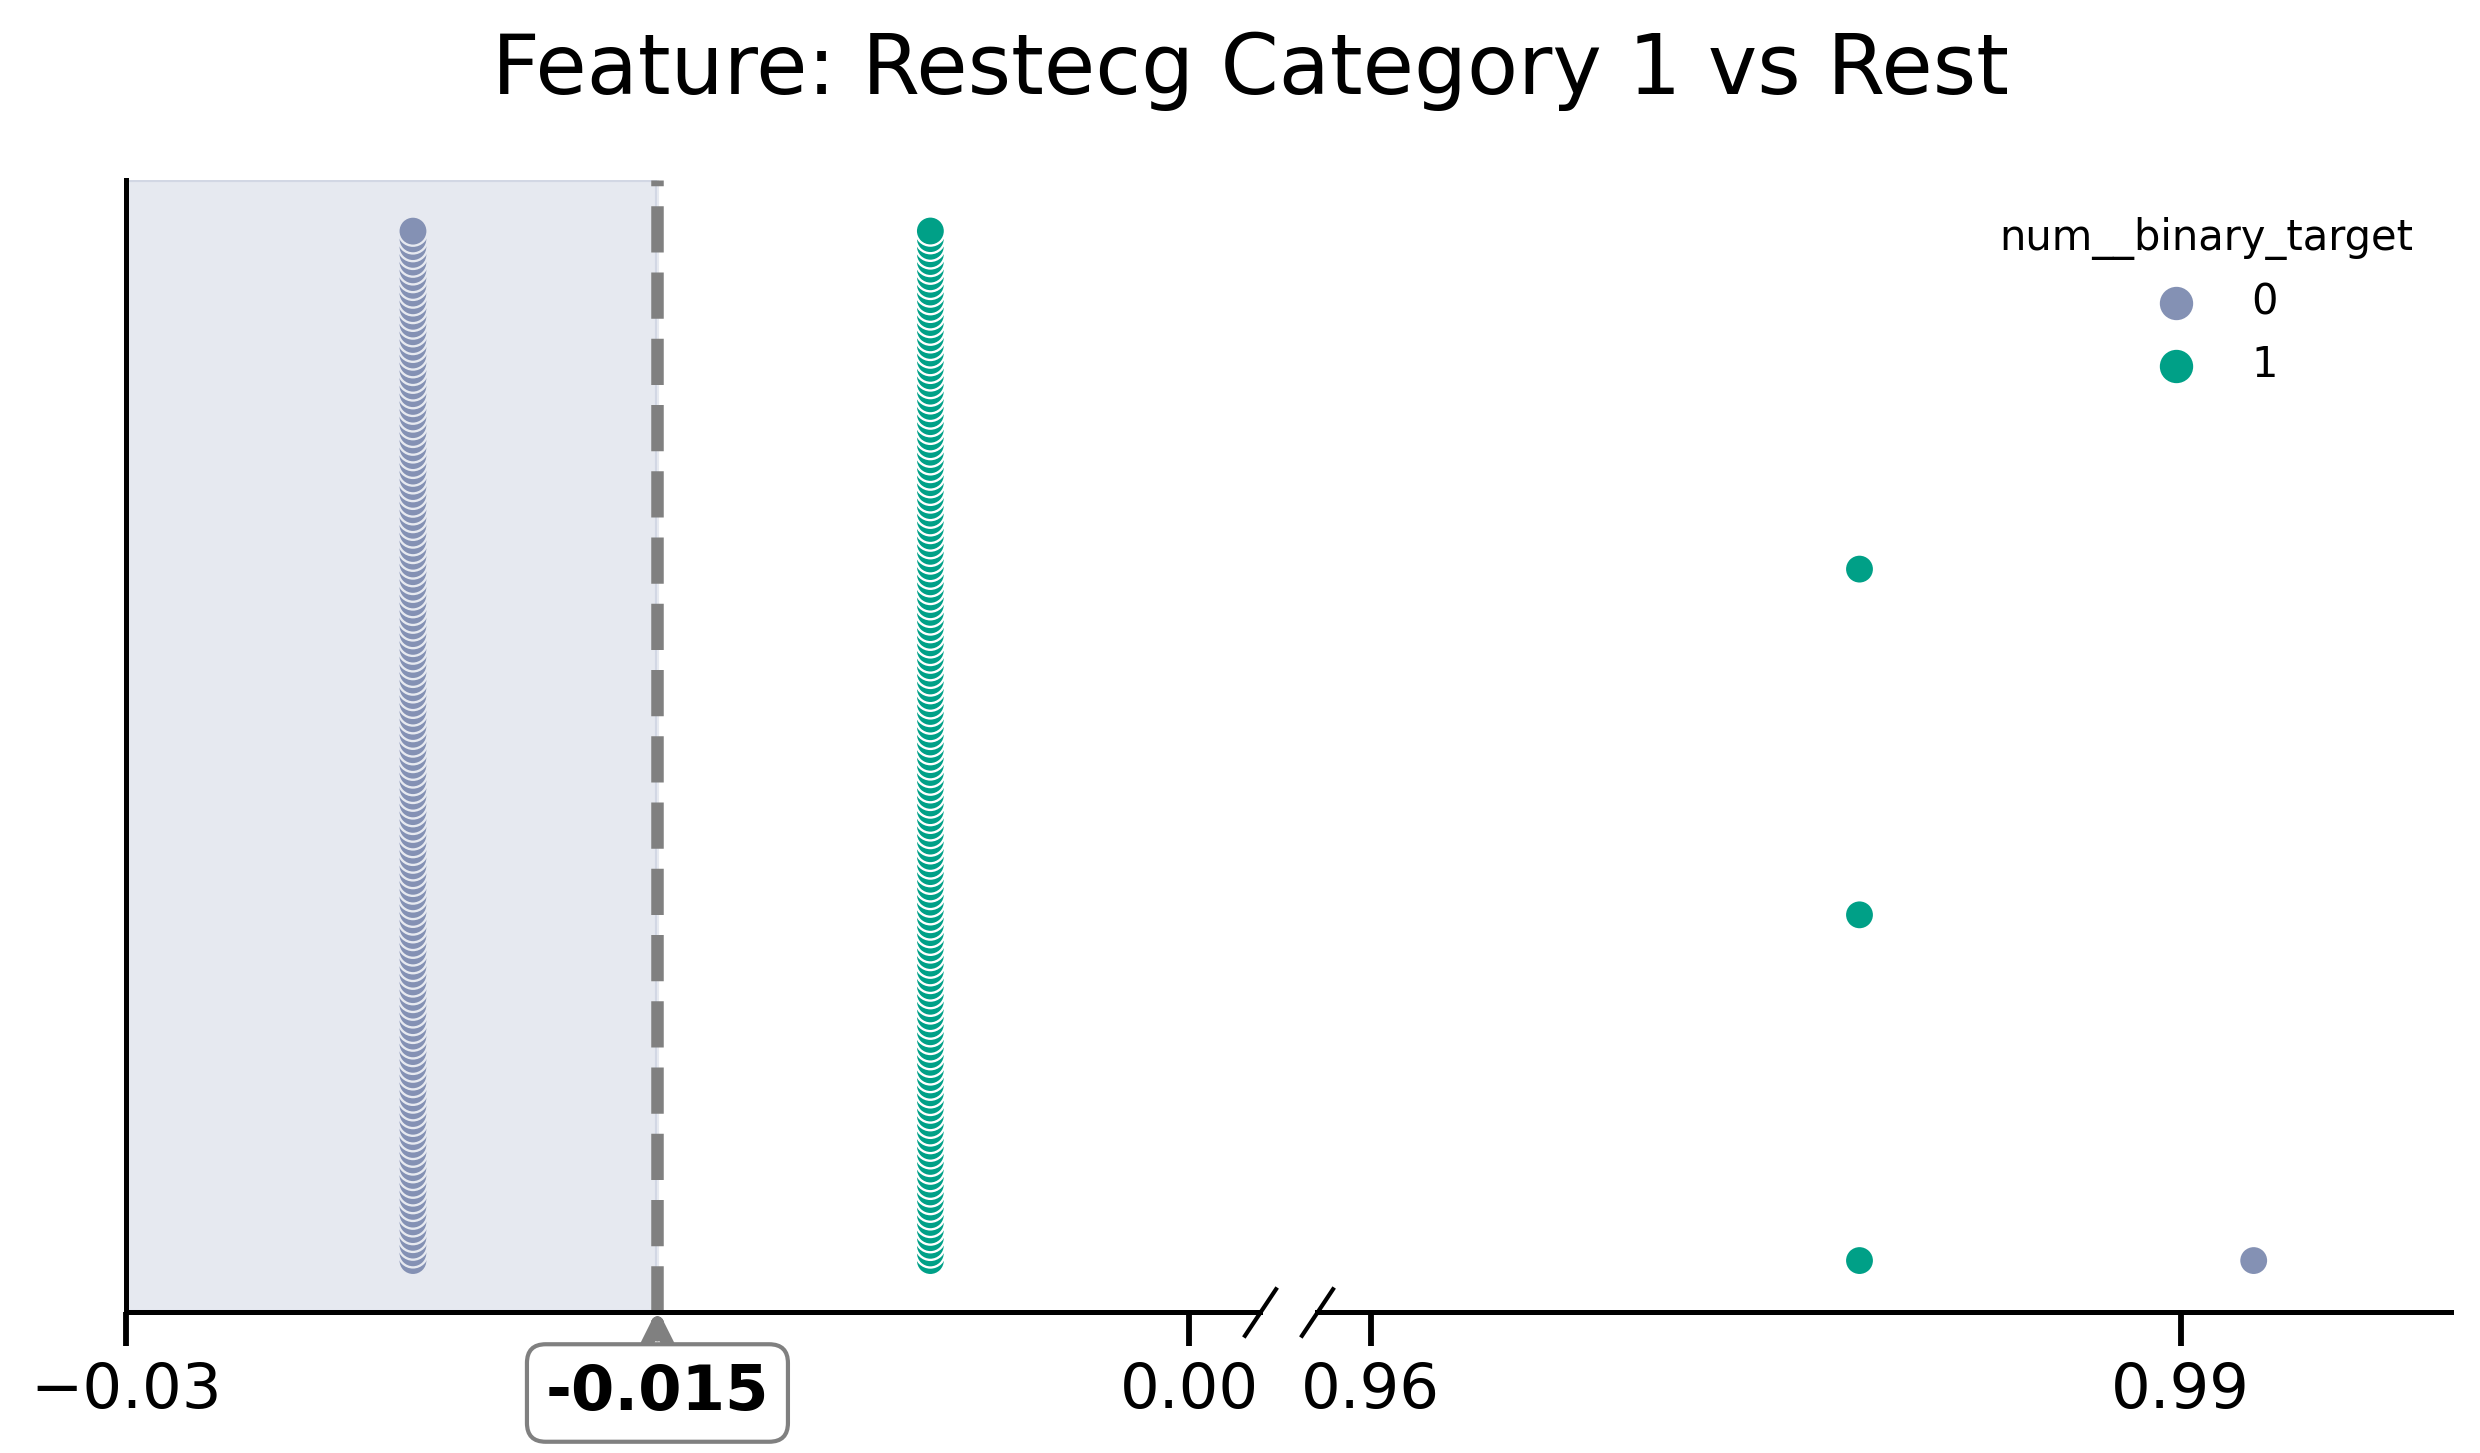

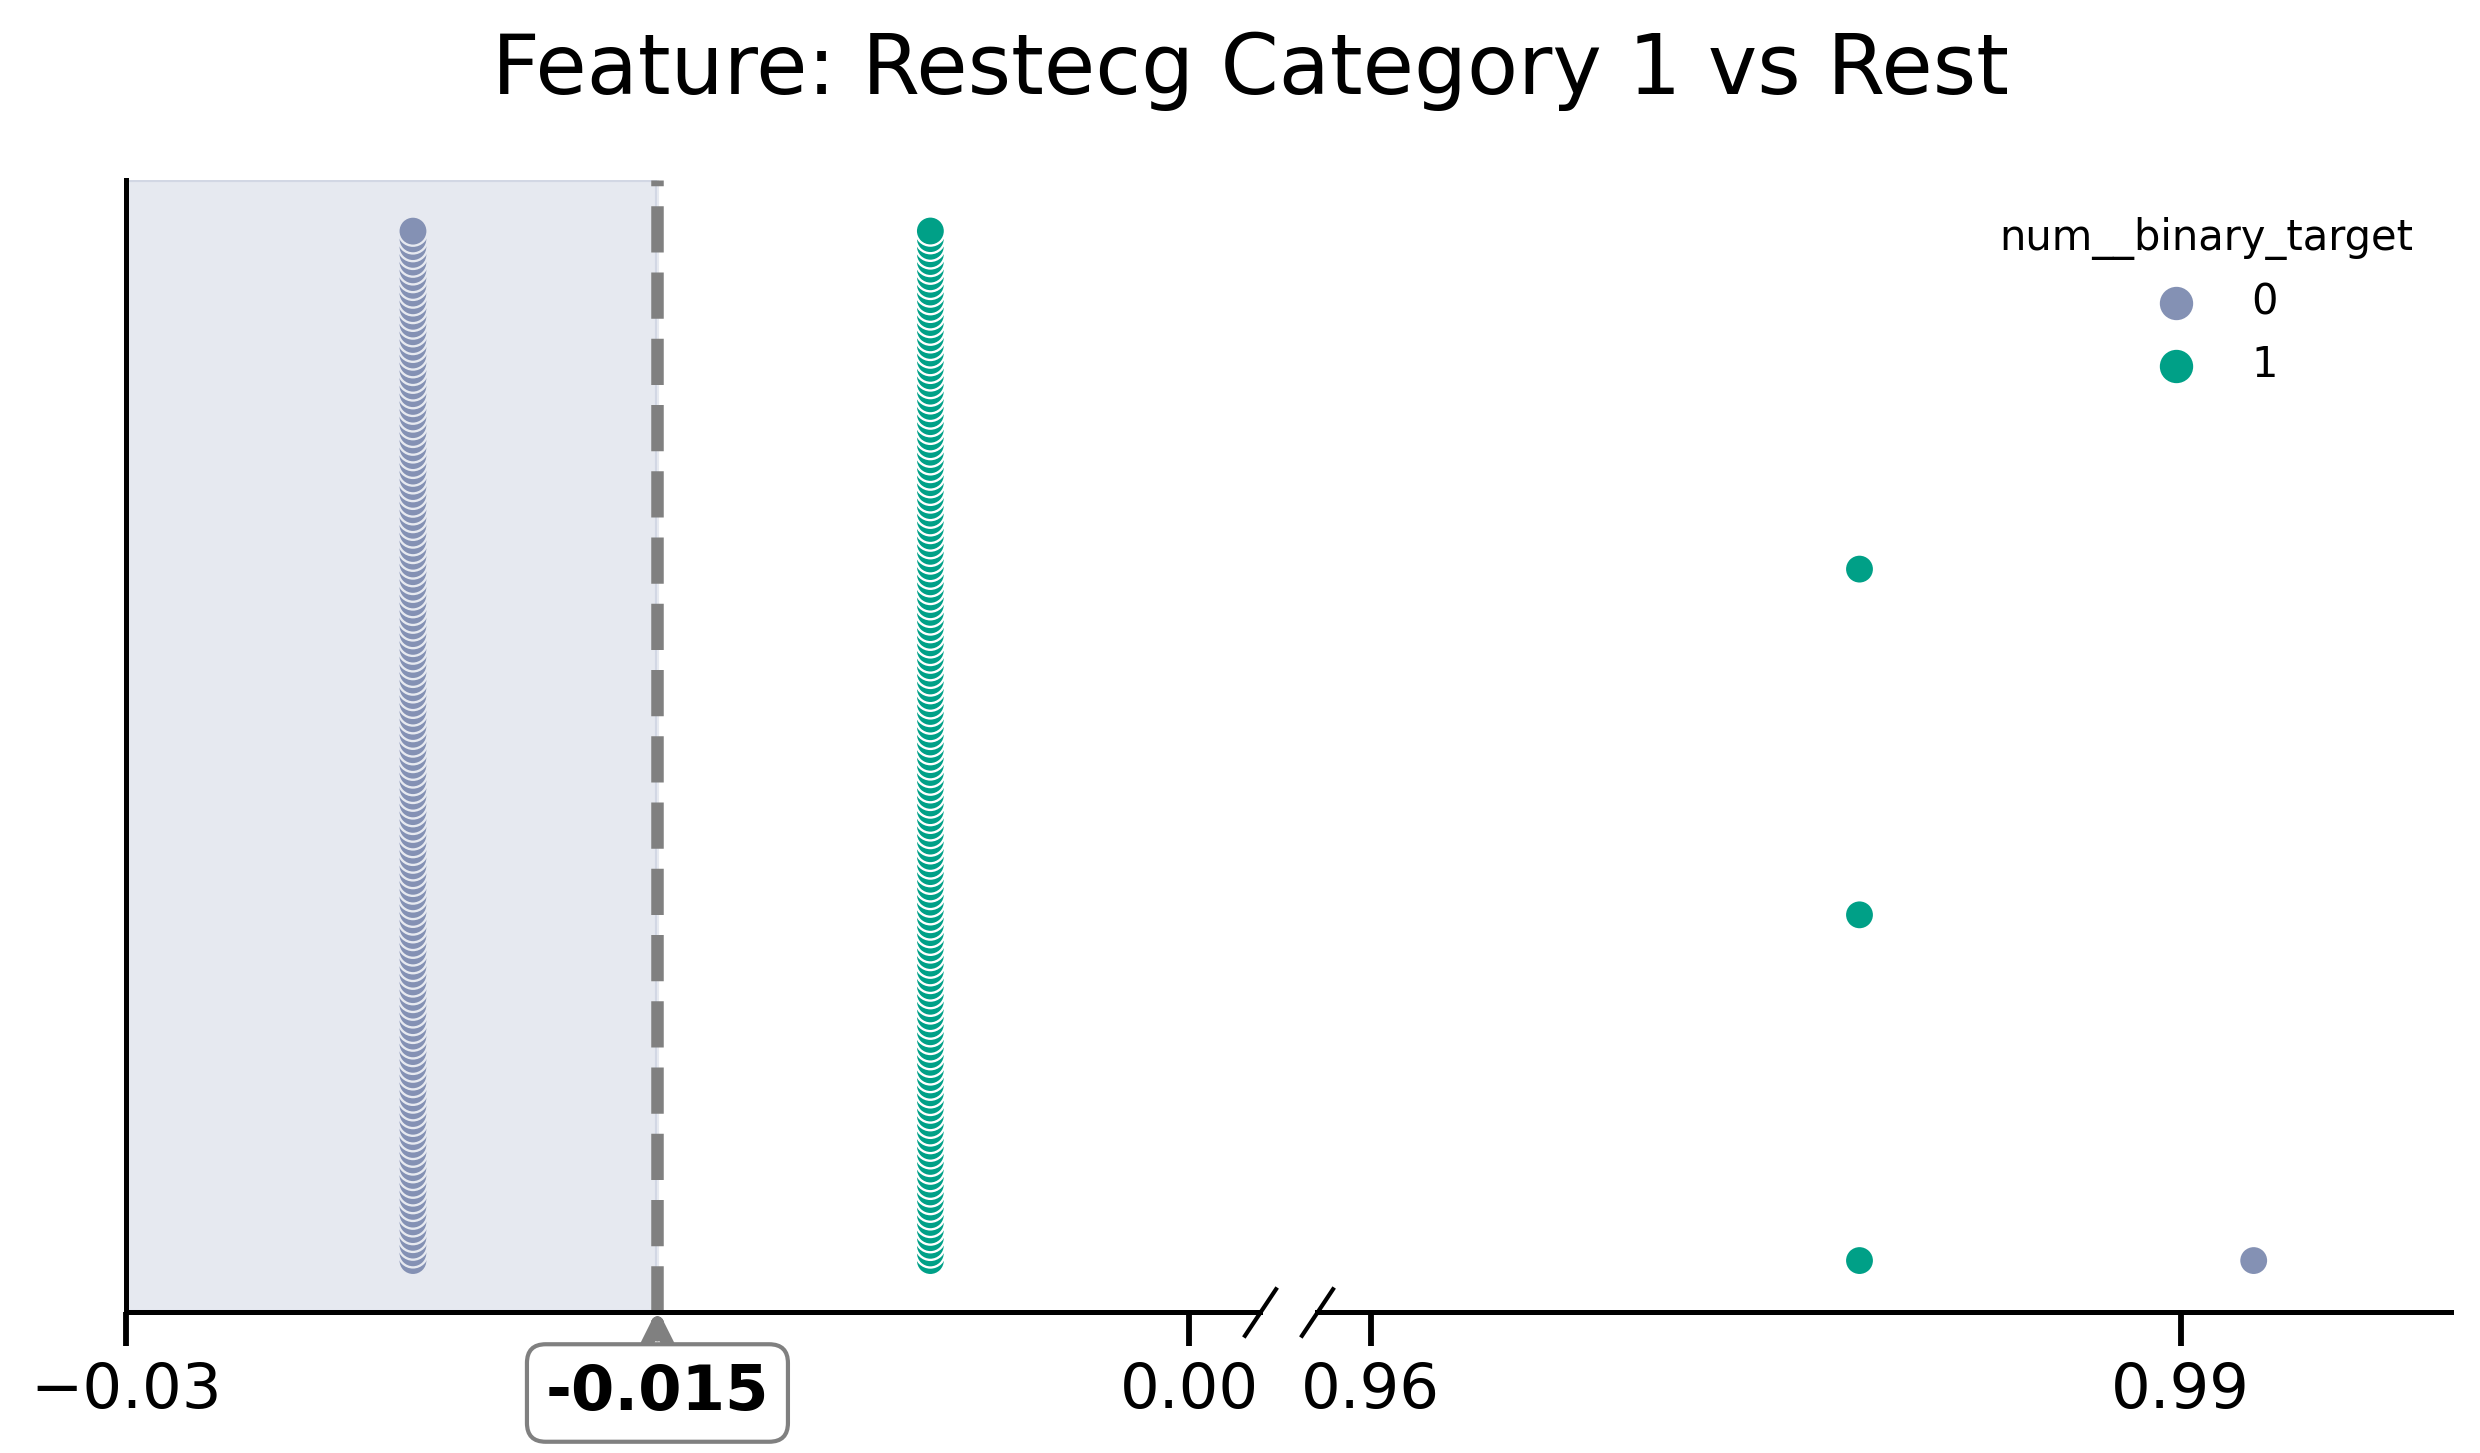

In [11]:

def plot_discont(X, hue, data, left_lim, right_lim, colors=None, title=''):
    df_left = data.query(f'{X} < {left_lim[1]}').copy()
    df_right = data.query(f'{X} > {right_lim[0]}').copy()
    assert len(df_left) + len(df_right) == len(data)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[10, 5], sharey=True)
    fig.subplots_adjust(wspace=0.05)
    fig.suptitle(title)

    df_right['ccount'] = df_right.groupby(y).cumcount()
    y_value_counts_right = df_right[y].value_counts()

    df_right['plot_y'] = (
        df_right
        .apply(
            lambda row: row['ccount'] / y_value_counts_right[row[y]],
            axis=1)
    )

    df_left['ccount'] = df_left.groupby(y).cumcount()
    y_value_counts_left = df_left[y].value_counts()
    df_left['plot_y'] = (
        df_left
        .apply(lambda row: row['ccount'] / y_value_counts_left[row[y]], axis=1)
    )

    palette_left = sns.color_palette(
        np.array(colors)[y_value_counts_left.index.values])
    palette_right = sns.color_palette(
        np.array(colors)[y_value_counts_right.index.values])
    sns.scatterplot(x=X, y='plot_y',  hue=hue,
                    data=df_left, ax=ax1, palette=palette_left)
    sns.scatterplot(x=X, y='plot_y',  hue=hue,
                    data=df_right, ax=ax2, palette=palette_right)

    ax1.set_xlim(left_lim[0], left_lim[1])
    ax1.get_legend().set_visible(False)
    ax1.spines.right.set_visible(False)
    ax1.set_yticklabels([])
    ax1.set_ylabel('')
    ax1.tick_params(left=False)

    # ax2
    ax2.spines.left.set_visible(False)
    ax2.yaxis.tick_left()
    ax2.tick_params(left=False)
    ax2.set_xlim(right_lim[0], right_lim[1])

    d = 1.5  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                  linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([1], [0], transform=ax1.transAxes, **kwargs)
    ax2.plot([0], [0], transform=ax2.transAxes, **kwargs)

    # titles
    ax1.set_xlabel('')
    ax2.set_xlabel('')
    return fig, (ax1, ax2)


df_removed[y] = df[y]
fig, (ax1, ax2) = plot_discont('restecg_1__categorical', y,
                               df_removed, (-.03, .002), (.958, 1),
                               colors=[green, purple],
                               title='Feature: Restecg Category 1 vs Rest'

                               )
print("threshold=", model_rm.named_steps.decisiontreeclassifier.tree_.threshold)

ax1.axvline(x=-.015, color='grey', linestyle='dashed', lw=3)
ax1.axvspan(-.03, -.015, color=purple, alpha=.2)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.03))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.03))

# visuals as we will make it smaller later we increase size
ax1.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
fig.suptitle("Feature: Restecg Category 1 vs Rest", size=20)

y_ground = ax1.transAxes.inverted().transform([0, 0])[1]
y_text = ax1.transAxes.inverted().transform([0, -.1])[1]

ax1.annotate("-0.015", xy=(-.015, 0.01), xytext=(-.015, -0.045),

             xycoords=ax1.get_xaxis_transform(),
             verticalalignment='top',
             ha="center",
             arrowprops=dict(arrowstyle="->", color="grey", linewidth=3),
             bbox=dict(boxstyle="round", fc="w", color="grey"), fontsize=15,
             weight="semibold"

             )

fig.savefig('./saved_figures/heart_restecg__cat_1.svg')
fig

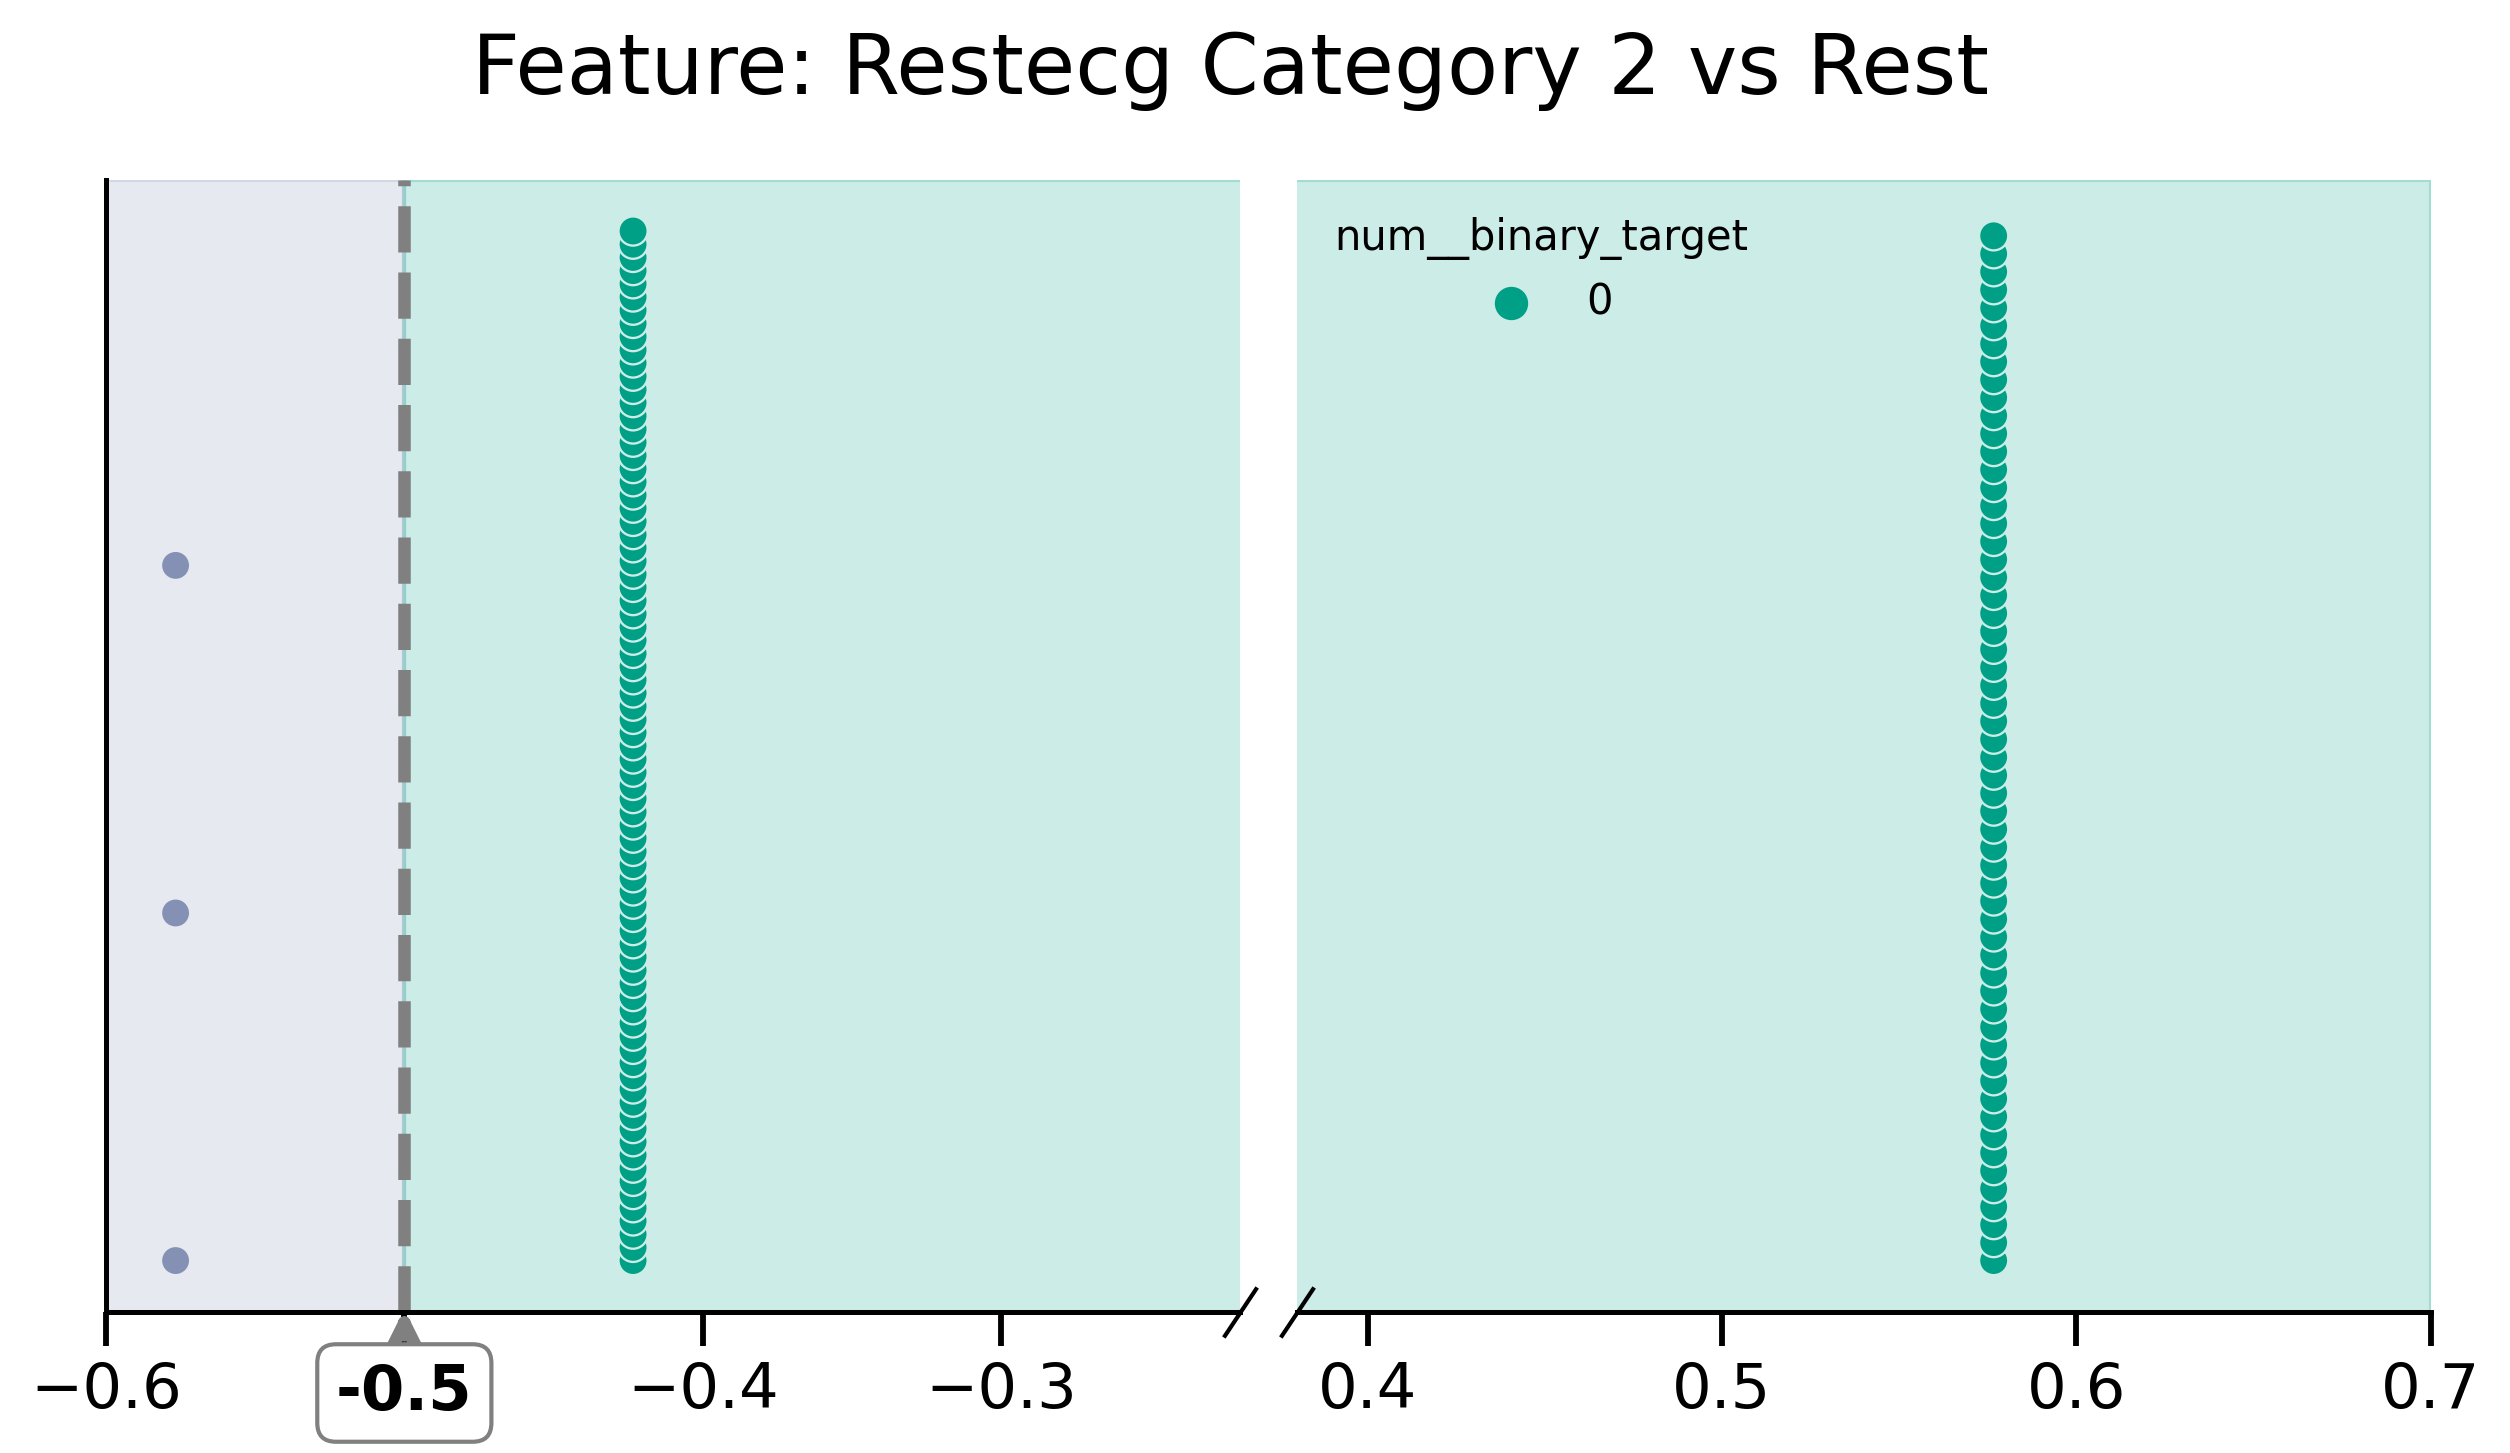

In [12]:
mask_selection = df_removed['restecg_1__categorical'] > -.015

fig, (ax1, ax2) = plot_discont('restecg_2__categorical', y,
                               df_removed[mask_selection],
                               (-.6, -.22), (.38, .7),
                               colors=[green, purple],
                               title='Feature: Restecg Category 2 vs Rest'
                               )


ax1.axvline(x=-.5, color='grey', linestyle='--', lw=3)
ax1.axvspan(-.6, -.5, color=purple, alpha=.2)
ax1.axvspan(-.5, -.1, color=green, alpha=.2)
ax2.axvspan(.35, .7, color=green, alpha=.2)

ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.1))

# visuals as we will make it smaller later we increase size
ax1.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
fig.suptitle("Feature: Restecg Category 2 vs Rest", size=20)

ax1.annotate("-0.5", xy=(-.5, .01), xytext=(-.5, -0.045),
             xycoords=ax1.get_xaxis_transform(),
             verticalalignment='top',
             ha="center",
             arrowprops=dict(arrowstyle="->", color="grey", linewidth=3),
             bbox=dict(boxstyle="round", fc="w", color="grey"), fontsize=15,
             weight="semibold"

             )
fig.savefig('./saved_figures/heart_restecg__cat_2.svg')

Simulations: Impact of Small Changes in Features Leading to Leakage.
We only change one feature value per fold to 1 or 0 where it was 0 or 1 respectivley
both taget and feature are here binary.
These simulations use only KFold for instead of Repeated KFold

In [13]:
target = np.array([[0, 1]*500]).flatten()
feat_1 = np.array([[0]*2 + [1]*2]*250).flatten()

feat_2 = feat_1.copy()

for i, ii in zip([97, 98, 197, 198, 297, 298, 397, 398, 497, 498, 597, 598,
                  697, 698, 797, 798, 897, 898, 997, 998],
                 [1, 0]*10):
    feat_2[i] = ii
df = pd.DataFrame(dict(feat_1=feat_1,
                       feat_2=feat_2,
                       conf=target, target=target))

In [14]:
np.random.seed(9464508)
scores_1 = run_cross_validation(
    X=['feat_1'], y='target', data=df,
    model=DecisionTreeClassifier(), preprocess_X=['zscore'], cv=KFold(10), scoring='roc_auc'

)
scores_1 = scores_1.test_score

scores_2 = run_cross_validation(
    X=['feat_2'], y='target', data=df,
    model=DecisionTreeClassifier(), preprocess_X=['zscore'], cv=KFold(10), scoring='roc_auc'
)

scores_2 = scores_2.test_score
print("No Removal:")
print('Scores Feat 1 (balanced): M = '
      f'{scores_1.mean():.4f}, sd = {scores_1.std():.4f}')

save_paper_val(base_save_paper, "reasons_low_perc", "raw",
               "mean_carefully_constructed_balanced.txt", scores_1.mean())

save_paper_val(base_save_paper, "reasons_low_perc", "raw",
               "std_carefully_constructed_balanced.txt", scores_1.std())

print('Scores Feat 2 (conditional feature imbalance to TaCo in each fold): M = '
      f'{scores_2.mean():.4f}, sd = {scores_2.std():.4f}')

save_paper_val(base_save_paper, "reasons_low_perc", "raw",
               "mean_carefully_constructed.txt", scores_2.mean())

save_paper_val(base_save_paper, "reasons_low_perc", "raw",
               "std_carefully_constructed.txt", scores_2.std())

No Removal:
Scores Feat 1 (balanced): M = 0.5000, sd = 0.0000
Scores Feat 2 (conditional feature imbalance to TaCo in each fold): M = 0.5200, sd = 0.0000


Now we do the same but with TaCo removal

In [15]:
results_1 = run_cross_validation(
    X=['feat_1'], confounds=['conf'], y='target', data=df,
    model=DecisionTreeClassifier(), preprocess_X=['zscore', 'remove_confound'],
    preprocess_confounds=['zscore'], cv=KFold(10), scoring='roc_auc'

)
score_1 = results_1.test_score

results_2 = run_cross_validation(
    X=['feat_2'], confounds=['conf'], y='target', data=df,
    model=DecisionTreeClassifier(), preprocess_X=['zscore', 'remove_confound'],
    preprocess_confounds=['zscore'], cv=KFold(10), scoring='roc_auc'

)
scores_2 = results_2.test_score
print(
    'Scores Feat 1 (balanced): M = '
    f'Mean = {scores_1.mean():.4f}, sd = {scores_1.std():.4f} \n'
    'Scores Feat 2 (conditional feature imbalance to TaCo in each folds): '
    f'Mean = {scores_2.mean():.4f}, sd = {scores_2.std():.4f}'

)

save_paper_val(base_save_paper, "reasons_low_perc", "removed",
               "mean_carefully_constructed_balanced.txt", scores_1.mean())

save_paper_val(base_save_paper, "reasons_low_perc", "removed",
               "std_carefully_constructed_balanced.txt", scores_1.std())

save_paper_val(base_save_paper, "reasons_low_perc", "removed",
               "mean_carefully_constructed.txt", scores_2.mean())

save_paper_val(base_save_paper, "reasons_low_perc", "removed",
               "std_carefully_constructed.txt", scores_2.std())

Scores Feat 1 (balanced): M = Mean = 0.5000, sd = 0.0000 
Scores Feat 2 (conditional feature imbalance to TaCo in each folds): Mean = 1.0000, sd = 0.0000
